In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import copy
import time

In [2]:
def distance(a, b):
    return round(np.sqrt(( a[0] - b[0])**2 + (a[1]) - b[1])**2)

def calc_distance_sum(cycle, distance_matrix):
    suma = 0
    for i in range(1, len(cycle)):
        suma += distance_matrix[cycle[i-1], cycle[i]]
    return suma

In [3]:
def plot_results(cycles, points_matrix):
    plt.scatter(points_matrix[..., 0], points_matrix[..., 1])
    plt.plot(points_matrix[cycles[0], 0], points_matrix[cycles[0], 1], 'r')
    plt.plot(points_matrix[cycles[1], 0], points_matrix[cycles[1], 1], 'g')
    plt.show()

def plot_results2(cycles, cycles2, points_matrix):
    plt.scatter(points_matrix[..., 0], points_matrix[..., 1])
    plt.plot(points_matrix[cycles[1], 0], points_matrix[cycles[1], 1], 'g')
    plt.plot(points_matrix[cycles[0], 0], points_matrix[cycles[0], 1], 'r')

    plt.plot(points_matrix[cycles2[1], 0], points_matrix[cycles2[1], 1], 'b')
    plt.plot(points_matrix[cycles2[0], 0], points_matrix[cycles2[0], 1], 'orange')

    plt.show()

In [4]:
def solve_cycle(distance_matrix, start = -1):
    remaining = [i for i in range(distance_matrix.shape[0])]
    if start == -1:
        x = np.random.choice(remaining)
    else:
        x = start
    first_cycle = [x]
    remaining.remove(x)
    ind = np.argpartition(distance_matrix[x,:], -2)[-2:]
    second_x = ind.tolist()
    second_x.remove(x)
    second_x = second_x[0]
    second_cycle = [second_x]
    remaining.remove(second_x)

    cycles = [first_cycle, second_cycle]

    for cycle in cycles:
        min_node = remaining[np.argmin(distance_matrix[cycle[-1]][remaining])]
        cycle.append(min_node)
        remaining.remove(min_node)

    while remaining:
        for cycle in cycles:
            cycle.append(cycle[0])
            best_node = None
            lowest_distance_increase = np.inf
            best_index = None

            for i in range(len(cycle) - 1):
                for remaining_node in remaining:
                    distance_increase = distance_matrix[cycle[i]][remaining_node] + distance_matrix[remaining_node][cycle[i+1]] - distance_matrix[cycle[i]][cycle[i+1]]
                    if distance_increase < lowest_distance_increase:
                        lowest_distance_increase = distance_increase
                        best_node = remaining_node
                        best_index = i

            cycle.insert(best_index + 1, best_node)
            # plot_results(cycles)
            remaining.remove(best_node)
            cycle.pop()

    for cycle in cycles:
        cycle.append(cycle[0])
    return cycles

def solve_random(distance_matrix):
    remaining = [i for i in range(distance_matrix.shape[0])]
    cycles = [[], []]
    append_to_cycle = 0
    while len(remaining) > 0:
        x = np.random.choice(remaining)
        cycles[append_to_cycle].append(x)
        remaining.remove(x)
        append_to_cycle = 1 - append_to_cycle

    for cycle in cycles:
        cycle.append(cycle[0])
    return cycles

In [39]:
def shuffled_outside_swap_candidates(paths):
    arr = [[x,y] for x in range(len(paths[0])) for y in range(len(paths[1]))]
    random.shuffle(arr)
    return arr

def shuffled_inside_swap_candidates(path):
    arr = []
    for i in range(len(path)):
        for j in range(i+1, len(path) - 1):
            arr.append([i,j])
    random.shuffle(arr)
    return arr

def swap_vertice_cost(distance_matrix, path, index, new_city):
    path_length = len(path)
    previous = path[(index-1) % path_length]
    current = path[index]
    next = path[(index+1) % path_length]
    return distance_matrix[previous, new_city] + distance_matrix[new_city, next] - distance_matrix[previous, current] - distance_matrix[current, next]

def swap_vertice_outside_cost(distance_matrix, paths, i, j):
    return swap_vertice_cost(distance_matrix, paths[0], i, paths[1][j]) + swap_vertice_cost(distance_matrix, paths[1], j, paths[0][i])

def swap_vertice_inside_cost(distance_matrix, path, i, j): # can only use candidates from shuffled_inside_swap_candidates function
    path_length = len(path)
    previous1 = path[(i-1) % path_length]
    current1 = path[i]
    next1 = path[(i+1) % path_length]
    previous2 = path[(j-1) % path_length]
    current2 = path[j]
    next2 = path[(j+1) % path_length]
    if abs(i-j) == 1: # because if they are neighbours they can become each other next vertex in path, we also dont include distance between them in equation because it would be reduced anyway
        return distance_matrix[previous1, current2] + distance_matrix[current1, next2] - distance_matrix[previous1, current1] - distance_matrix[current2, next2]
    if i in [0, path_length-1] and j in [0, path_length-1]:
        return distance_matrix[current2, next1] + distance_matrix[previous2, current1] - distance_matrix[current1, next1] - distance_matrix[previous2, current2]
    else:
        new_distance = distance_matrix[previous1, current2] + distance_matrix[current2, next1] + distance_matrix[previous2, current1] + distance_matrix[current1, next2]
        old_distance = distance_matrix[previous1, current1] + distance_matrix[current1, next1] + distance_matrix[previous2, current2] + distance_matrix[current2, next2]
        return new_distance - old_distance

def swap_edge_inside_cost(distance_matrix, path, i, j):
    if i == 0 and j == len(path) - 2:
        return 0
    path_length = len(path)
    previous1 = path[(i-1) % path_length]
    current1 = path[i]
    current2 = path[j]
    next2 = path[(j+1) % path_length]
    return distance_matrix[previous1, current2] + distance_matrix[current1, next2] - distance_matrix[previous1, current1] - distance_matrix[current2, next2]

def swap_vertice_outside(paths, i, j):
    k = paths[1][j]
    paths[1][j] = paths[0][i]
    paths[0][i] = k

def swap_vertice_inside(path, i, j):
    k = path[j]
    path[j] = path[i]
    path[i] = k

def swap_edges_inside(path, i, j):
    path[i:j+1] = reversed(path[i:j+1])

def solve_greedy(distance_matrix, initial_cycles, neighborhood='vertex'):
    cycles = copy.deepcopy(initial_cycles)
    cycles[0].pop()
    cycles[1].pop()
    outside_checked = False
    inside_checked = False
    if neighborhood == 'vertex':
        while not (outside_checked and inside_checked):
            new_change_found = False
            if (not outside_checked and inside_checked) or (not outside_checked and np.random.random() < 0.5):
                outside_swap_candidates = shuffled_outside_swap_candidates(cycles)
                for candidates in outside_swap_candidates:
                    delta = swap_vertice_outside_cost(distance_matrix, cycles, candidates[0], candidates[1])
                    if delta < 0:
                        swap_vertice_outside(cycles, candidates[0], candidates[1])
                        new_change_found = True
                        break
                if new_change_found:
                    outside_checked = False
                    inside_checked = False
                    continue
                outside_checked = True
            if not inside_checked:
                order = np.arange(len(cycles))
                np.random.shuffle(order)
                for i in order:
                    inside_swap_candidates = shuffled_inside_swap_candidates(cycles[i])
                    for candidates in inside_swap_candidates:
                        delta = swap_vertice_inside_cost(distance_matrix, cycles[i], candidates[0], candidates[1])
                        if delta < 0:
                            swap_vertice_inside(cycles[i], candidates[0], candidates[1])
                            new_change_found = True
                            break
                if new_change_found:
                    outside_checked = False
                    inside_checked = False
                    continue
                inside_checked = True
    else:
        while not (outside_checked and inside_checked):
            new_change_found = False
            if (not outside_checked and inside_checked) or (not outside_checked and np.random.random() < 0.5):
                outside_swap_candidates = shuffled_outside_swap_candidates(cycles)
                for candidates in outside_swap_candidates:
                    delta = swap_vertice_outside_cost(distance_matrix, cycles, candidates[0], candidates[1])
                    if delta < 0:
                        swap_vertice_outside(cycles, candidates[0], candidates[1])
                        new_change_found = True
                        break
                if new_change_found:
                    outside_checked = False
                    inside_checked = False
                    continue
                outside_checked = True
            if not inside_checked:
                order = np.arange(len(cycles))
                np.random.shuffle(order)
                for i in order:
                    inside_swap_candidates = shuffled_inside_swap_candidates(cycles[i])
                    for candidates in inside_swap_candidates:
                        delta = swap_edge_inside_cost(distance_matrix, cycles[i], candidates[0], candidates[1])
                        if delta < 0:
                            swap_edges_inside(cycles[i], candidates[0], candidates[1])
                            new_change_found = True
                            break
                if new_change_found:
                    outside_checked = False
                    inside_checked = False
                    continue
                inside_checked = True

    for cycle in cycles:
        cycle.append(cycle[0])
    return cycles

def solve_steepest(distance_matrix, initial_cycles, neighborhood='vertex'):
    cycles = copy.deepcopy(initial_cycles)
    cycles[0].pop()
    cycles[1].pop()

    new_change_found = True
    best_candidates = None
    is_change_outside = None
    best_cycle_index = 0
    if neighborhood == 'vertex':
        while new_change_found:
            new_change_found = False
            best_delta = np.inf
            outside_swap_candidates = shuffled_outside_swap_candidates(cycles)
            for candidates in outside_swap_candidates:
                delta = swap_vertice_outside_cost(distance_matrix, cycles, candidates[0], candidates[1])
                if delta < 0 and delta < best_delta:
                    best_delta = delta
                    best_candidates = [candidates[0], candidates[1]]
                    is_change_outside = True
                    new_change_found = True

            for i in range(len(cycles)):
                inside_swap_candidates = shuffled_inside_swap_candidates(cycles[i])
                for candidates in inside_swap_candidates:
                    delta = swap_vertice_inside_cost(distance_matrix, cycles[i], candidates[0], candidates[1])
                    if delta < 0 and delta < best_delta:
                        best_delta = delta
                        best_candidates = [candidates[0], candidates[1]]
                        best_cycle_index = i
                        is_change_outside = False
                        new_change_found = True

            if new_change_found:
                if is_change_outside:
                    swap_vertice_outside(cycles, best_candidates[0], best_candidates[1])
                else:
                    swap_vertice_inside(cycles[best_cycle_index], best_candidates[0], best_candidates[1])

    else:
        while new_change_found:
            new_change_found = False
            best_delta = np.inf
            outside_swap_candidates = shuffled_outside_swap_candidates(cycles)
            for candidates in outside_swap_candidates:
                delta = swap_vertice_outside_cost(distance_matrix, cycles, candidates[0], candidates[1])
                if delta < 0 and delta < best_delta:
                    best_delta = delta
                    best_candidates = [candidates[0], candidates[1]]
                    is_change_outside = True
                    new_change_found = True

            for i in range(len(cycles)):
                inside_swap_candidates = shuffled_inside_swap_candidates(cycles[i])
                for candidates in inside_swap_candidates:
                    delta = swap_edge_inside_cost(distance_matrix, cycles[i], candidates[0], candidates[1])
                    if delta < 0 and delta < best_delta:
                        best_delta = delta
                        best_candidates = [candidates[0], candidates[1]]
                        best_cycle_index = i
                        is_change_outside = False
                        new_change_found = True

            if new_change_found:
                if is_change_outside:
                    swap_vertice_outside(cycles, best_candidates[0], best_candidates[1])
                else:
                    swap_vertice_inside(cycles[best_cycle_index], best_candidates[0], best_candidates[1])

    for cycle in cycles:
        cycle.append(cycle[0])
    return cycles

In [6]:
instances = ['./data/lab1/kroA100.txt', './data/lab1/kroB100.txt']
neighborhoods = ['vertex', 'edge']
strategies = [solve_greedy, solve_steepest]
starting_options = ['random', 'cycle']

def get_results():
    results = []
    times = []
    for instance in instances:
        with open(instance) as f:
            data = f.read()
        data = data.split('\n')
        data = pd.DataFrame([i.split(' ') for i in data])
        data = data.drop(0, axis=1)
        data = data.drop(100, axis=0)

        points_matrix = data.to_numpy()
        points_matrix = points_matrix.astype(int)
        matrix = []
        for i in range(100):
            matrix.append([])
            for j in range(100):
                matrix[i].append(points_matrix[i, :] - points_matrix[j, :])
        matrix = np.array(matrix)
        distance_matrix = np.sqrt(np.square(matrix[:, :, 0]) + np.square(matrix[:, :, 1]))

        for i in range(distance_matrix.shape[0]):
            distance_matrix[i, i] = np.inf

        for strategy in strategies:
            for neighborhood in neighborhoods:
                for starting_option in starting_options:
                    distances = []
                    algorithm_times = []
                    best_cycles = None
                    best_distance = np.inf
                    for i in range(distance_matrix.shape[0]):
                        if starting_option == 'random':
                            starting_cycles = solve_random(distance_matrix)
                        else:
                            starting_cycles = solve_cycle(distance_matrix, start=i)
                        start_time = time.time()
                        cycles = strategy(distance_matrix, starting_cycles, neighborhood)
                        algorithm_times.append(time.time() - start_time)
                        distances.append(calc_distance_sum(cycles[0], distance_matrix) + calc_distance_sum(cycles[1], distance_matrix))
                        if distances[-1] < best_distance:
                            best_distance = distances[-1]
                            best_cycles = copy.deepcopy(cycles)
                    times.append(dict(instance=instance, strategy=strategy.__name__, neighborhood=neighborhood, starting_option=starting_option, min_time=min(algorithm_times), mean_time=np.mean(algorithm_times), max_time=max(algorithm_times)))
                    results.append(dict(instance=instance, strategy=strategy.__name__, neighborhood=neighborhood, starting_option=starting_option, min_distance=min(distances), mean_distance=np.mean(distances), max_distance=max(distances)))
                    print(f'Intance: {instance}, strategy: {strategy.__name__}, neighborhood: {neighborhood}, starting_option: {starting_option}, best_distance: {best_distance}')
                    plot_results(best_cycles, points_matrix)
    return results, times

Intance: ./data/lab1/kroA100.txt, strategy: solve_greedy, neighborhood: vertex, starting_option: random, best_distance: 32056.596497725994


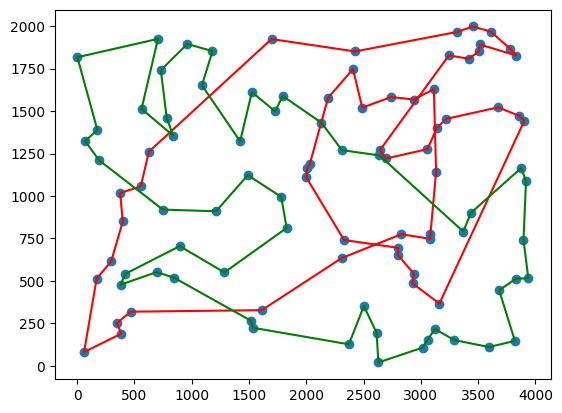

Intance: ./data/lab1/kroA100.txt, strategy: solve_greedy, neighborhood: vertex, starting_option: cycle, best_distance: 24680.22458290413


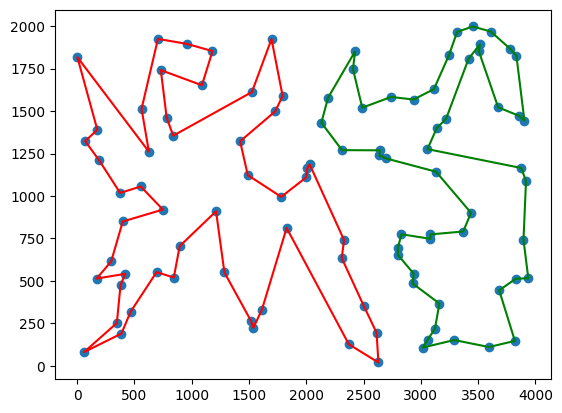

Intance: ./data/lab1/kroA100.txt, strategy: solve_greedy, neighborhood: edge, starting_option: random, best_distance: 26695.02019758457


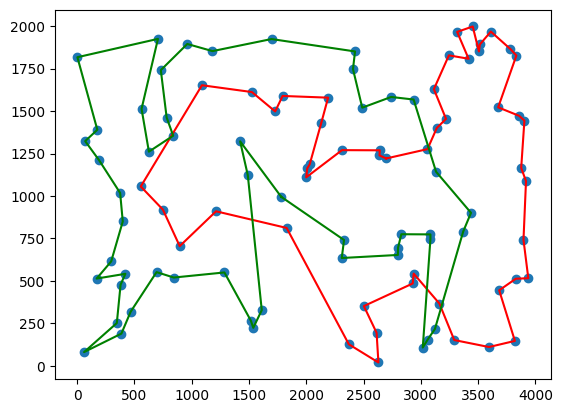

Intance: ./data/lab1/kroA100.txt, strategy: solve_greedy, neighborhood: edge, starting_option: cycle, best_distance: 23854.673016084336


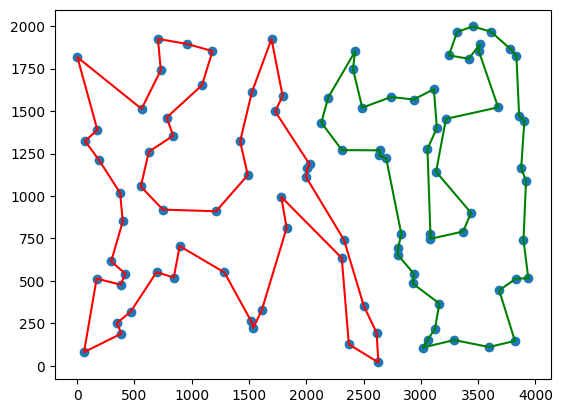

Intance: ./data/lab1/kroA100.txt, strategy: solve_steepest, neighborhood: vertex, starting_option: random, best_distance: 37097.460231583595


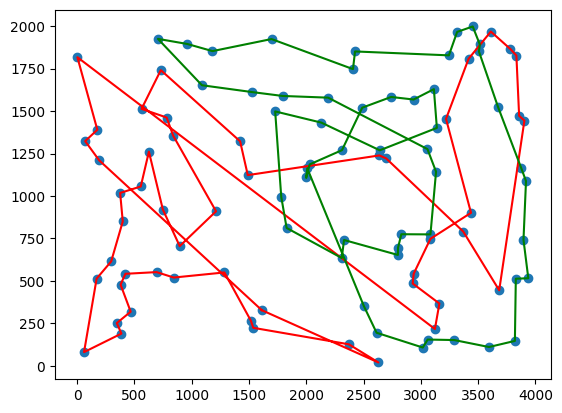

Intance: ./data/lab1/kroA100.txt, strategy: solve_steepest, neighborhood: vertex, starting_option: cycle, best_distance: 24816.944802228463


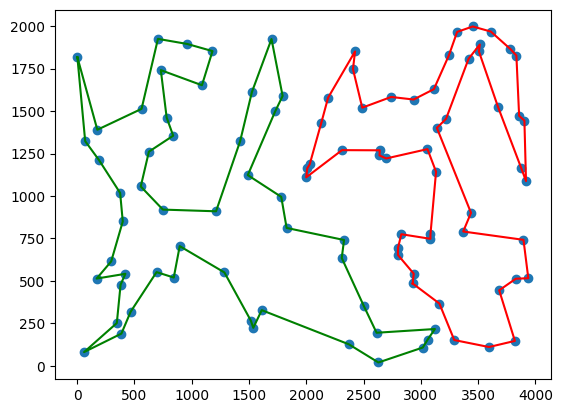

Intance: ./data/lab1/kroA100.txt, strategy: solve_steepest, neighborhood: edge, starting_option: random, best_distance: 26053.95044804203


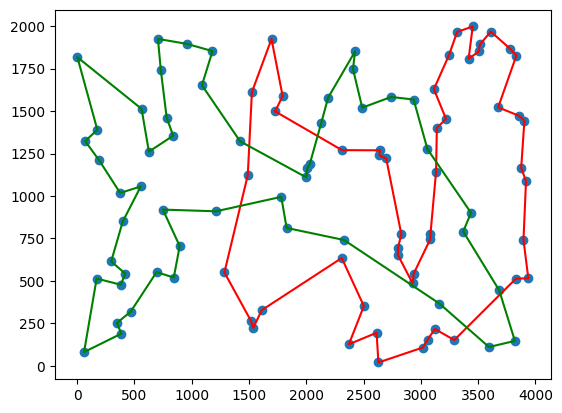

Intance: ./data/lab1/kroA100.txt, strategy: solve_steepest, neighborhood: edge, starting_option: cycle, best_distance: 24219.439900180834


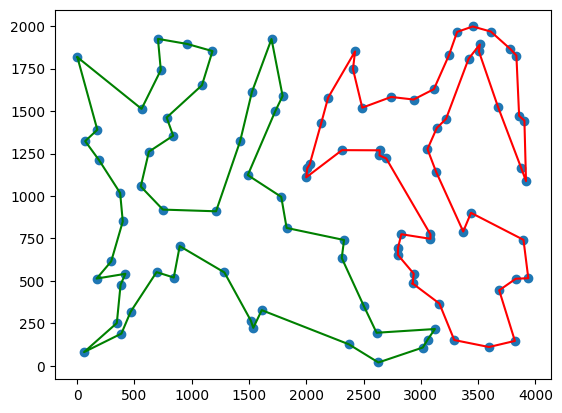

Intance: ./data/lab1/kroB100.txt, strategy: solve_greedy, neighborhood: vertex, starting_option: random, best_distance: 34167.10579453094


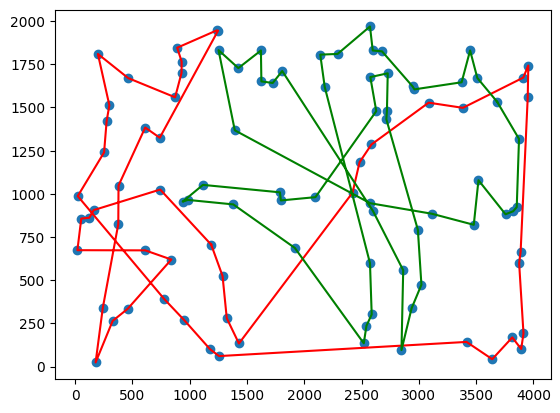

Intance: ./data/lab1/kroB100.txt, strategy: solve_greedy, neighborhood: vertex, starting_option: cycle, best_distance: 23544.263339358804


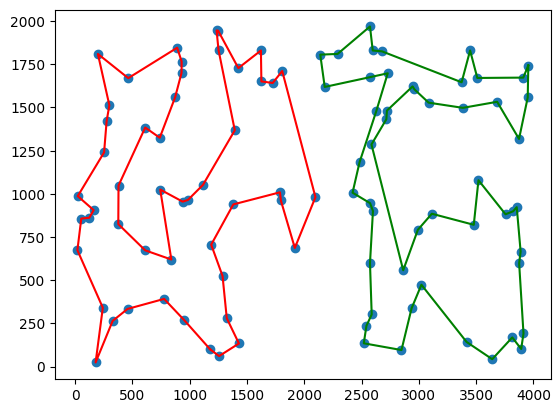

Intance: ./data/lab1/kroB100.txt, strategy: solve_greedy, neighborhood: edge, starting_option: random, best_distance: 25210.597392692158


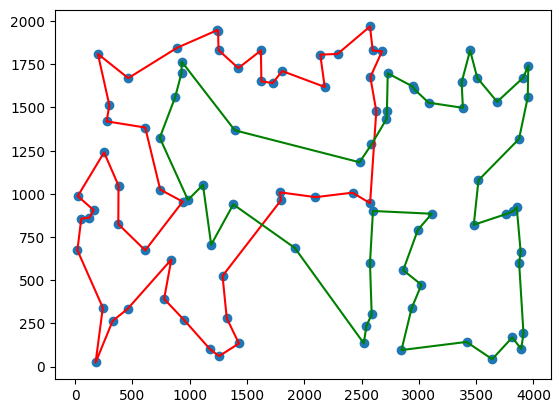

Intance: ./data/lab1/kroB100.txt, strategy: solve_greedy, neighborhood: edge, starting_option: cycle, best_distance: 22028.386198023854


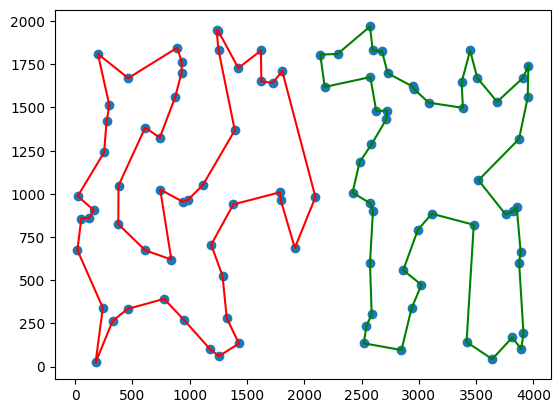

Intance: ./data/lab1/kroB100.txt, strategy: solve_steepest, neighborhood: vertex, starting_option: random, best_distance: 35215.660450424075


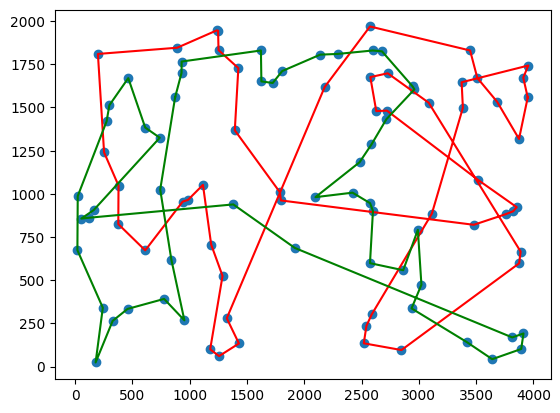

Intance: ./data/lab1/kroB100.txt, strategy: solve_steepest, neighborhood: vertex, starting_option: cycle, best_distance: 23544.263339358804


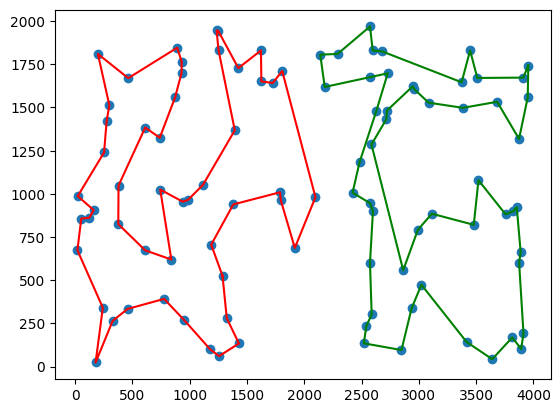

Intance: ./data/lab1/kroB100.txt, strategy: solve_steepest, neighborhood: edge, starting_option: random, best_distance: 25220.609623050623


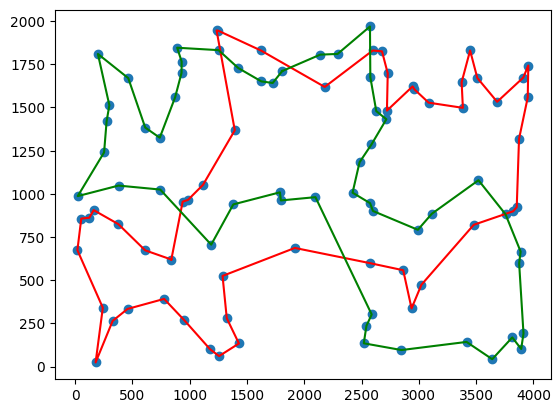

Intance: ./data/lab1/kroB100.txt, strategy: solve_steepest, neighborhood: edge, starting_option: cycle, best_distance: 22897.1964155105


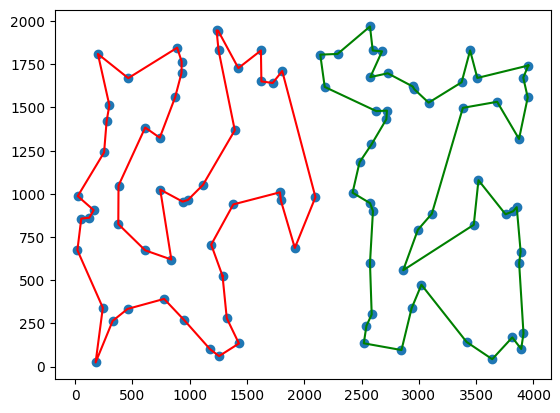

In [7]:
results, times = get_results()

In [8]:
pd.DataFrame(results)

,instance,strategy,neighborhood,starting_option,min_distance,mean_distance,max_distance
0,./data/lab1/kroA100.txt,solve_greedy,vertex,random,32056.596498,41621.906439,49456.789910
1,./data/lab1/kroA100.txt,solve_greedy,vertex,cycle,24680.224583,26859.436733,28821.181818
2,./data/lab1/kroA100.txt,solve_greedy,edge,random,26695.020198,28751.613166,31530.170120
3,./data/lab1/kroA100.txt,solve_greedy,edge,cycle,23854.673016,25895.637871,27907.493019
4,./data/lab1/kroA100.txt,solve_steepest,vertex,random,37097.460232,44149.027559,57588.822607
5,./data/lab1/kroA100.txt,solve_steepest,vertex,cycle,24816.944802,26810.176495,28819.139407
6,./data/lab1/kroA100.txt,solve_steepest,edge,random,26053.950448,28252.985425,31253.033331
7,./data/lab1/kroA100.txt,solve_steepest,edge,cycle,24219.439900,25666.260370,27830.711629
8,./data/lab1/kroB100.txt,solve_greedy,vertex,random,34167.105795,41100.627591,50186.325241
9,./data/lab1/kroB100.txt,solve_greedy,vertex,cycle,23544.263339,26884.220170,28183.468042


In [9]:
pd.DataFrame(times)

,instance,strategy,neighborhood,starting_option,min_time,mean_time,max_time
0,./data/lab1/kroA100.txt,solve_greedy,vertex,random,0.319710,0.481715,0.677975
1,./data/lab1/kroA100.txt,solve_greedy,vertex,cycle,0.023613,0.071240,0.155889
2,./data/lab1/kroA100.txt,solve_greedy,edge,random,0.309137,0.408275,0.579368
3,./data/lab1/kroA100.txt,solve_greedy,edge,cycle,0.022320,0.076352,0.160161
4,./data/lab1/kroA100.txt,solve_steepest,vertex,random,1.161363,1.451010,1.837124
5,./data/lab1/kroA100.txt,solve_steepest,vertex,cycle,0.049130,0.155021,0.274213
6,./data/lab1/kroA100.txt,solve_steepest,edge,random,1.804960,2.674347,3.810403
7,./data/lab1/kroA100.txt,solve_steepest,edge,cycle,0.166483,0.755777,1.424526
8,./data/lab1/kroB100.txt,solve_greedy,vertex,random,0.350830,0.471453,0.658663
9,./data/lab1/kroB100.txt,solve_greedy,vertex,cycle,0.020022,0.060476,0.140430


In [56]:
def get_results_random_walk():
    results = []
    instances = ['./data/lab1/kroA100.txt', './data/lab1/kroB100.txt']
    moves = [swap_vertice_outside, swap_vertice_inside, swap_edges_inside]
    for instance in instances:
        with open(instance) as f:
            data = f.read()
        data = data.split('\n')
        data = pd.DataFrame([i.split(' ') for i in data])
        data = data.drop(0, axis=1)
        data = data.drop(100, axis=0)

        points_matrix = data.to_numpy()
        points_matrix = points_matrix.astype(int)
        matrix = []
        for i in range(100):
            matrix.append([])
            for j in range(100):
                matrix[i].append(points_matrix[i, :] - points_matrix[j, :])
        matrix = np.array(matrix)
        distance_matrix = np.sqrt(np.square(matrix[:, :, 0]) + np.square(matrix[:, :, 1]))

        for i in range(distance_matrix.shape[0]):
            distance_matrix[i, i] = np.inf

        distances = []
        for i in range(distance_matrix.shape[0]):
            total_time = 0
            cycles = solve_random(distance_matrix)
            distance = calc_distance_sum(cycles[0], distance_matrix) + calc_distance_sum(cycles[1], distance_matrix)
            best_distance = distance
            best_cycles = copy.deepcopy(cycles)
            while total_time < 2.714136:
                start_time = time.time()
                move = np.random.choice(moves)
                if move == swap_vertice_outside:
                    candidates = shuffled_outside_swap_candidates(cycles)[0]
                    swap_vertice_outside(cycles, candidates[0], candidates[1])
                    
                elif move == swap_vertice_inside:
                    cycle_index = np.random.randint(2)
                    candidates = shuffled_inside_swap_candidates(cycles[cycle_index])[0]
                    swap_vertice_inside(cycles[cycle_index], candidates[0], candidates[1])
                else:
                    cycle_index = np.random.randint(2)
                    candidates = shuffled_inside_swap_candidates(cycles[cycle_index])[0]
                    swap_edges_inside(cycles[cycle_index], candidates[0], candidates[1])
                distance = calc_distance_sum(cycles[0], distance_matrix) + calc_distance_sum(cycles[1], distance_matrix)
                if distance < best_distance:
                    best_cycles = copy.deepcopy(cycles)
                    best_distance = distance
                total_time += time.time() - start_time
            distances.append(best_distance)
        results.append(dict(instance=instance,  min_distance=min(distances), mean_distance=np.mean(distances), max_distance=max(distances)))
        print(f'Intance: {instance}, best_distance: {best_distance}')
        plot_results(best_cycles, points_matrix)
    return results

Intance: ./data/lab1/kroA100.txt, best_distance: 140133.63852755283


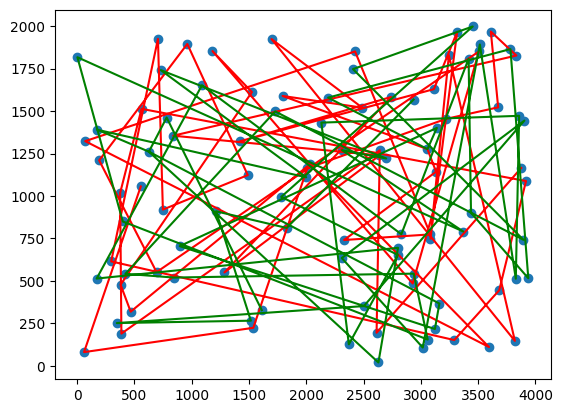

Intance: ./data/lab1/kroB100.txt, best_distance: 146065.0117443098


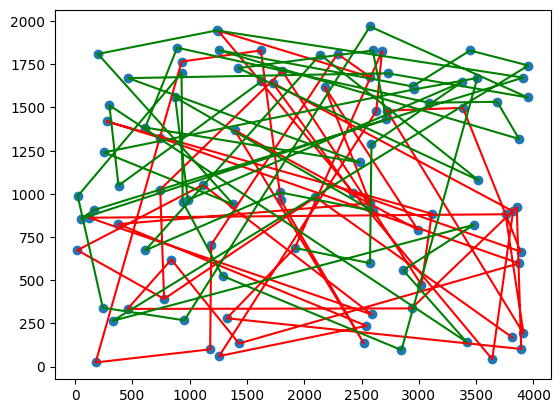

,instance,min_distance,mean_distance,max_distance
0,./data/lab1/kroA100.txt,135238.803507,143359.445809,150057.503114
1,./data/lab1/kroB100.txt,136665.625437,145110.951768,152566.841193


In [57]:
pd.DataFrame(get_results_random_walk())